In [1]:
import pandas as pd
from binance.client import Client

In [5]:
# Initialize the Binance client
api_key = 'your_api_key'
api_secret = 'your_api_secret'
client = Client(api_key, api_secret)

# Get historical data for BTCUSDT
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2010", "28 Feb, 2025")

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

btc = df[['open', 'close']].copy()
print(btc.head())

                     open          close
timestamp                               
2017-08-17  4261.48000000  4285.08000000
2017-08-18  4285.08000000  4108.37000000
2017-08-19  4108.37000000  4139.98000000
2017-08-20  4120.98000000  4086.29000000
2017-08-21  4069.13000000  4016.00000000


In [12]:
for _ in range(1, 5):
    btc[f'close_{_}'] = btc['close'].shift(_)

btc['day'] = range(1, len(btc) + 1)

btc['result'] = (btc['close'].astype(float) / btc['open'].astype(float)).apply(lambda x: 1 if x > 1.002 else 0)

print(btc.head())

                     open          close        close_1        close_2  \
timestamp                                                                
2017-08-17  4261.48000000  4285.08000000           None           None   
2017-08-18  4285.08000000  4108.37000000  4285.08000000           None   
2017-08-19  4108.37000000  4139.98000000  4108.37000000  4285.08000000   
2017-08-20  4120.98000000  4086.29000000  4139.98000000  4108.37000000   
2017-08-21  4069.13000000  4016.00000000  4086.29000000  4139.98000000   

                  close_3        close_4  result  day  
timestamp                                              
2017-08-17           None           None       1    1  
2017-08-18           None           None       0    2  
2017-08-19           None           None       1    3  
2017-08-20  4285.08000000           None       0    4  
2017-08-21  4108.37000000  4285.08000000       0    5  


In [15]:
btc_cleaned = btc.dropna()
print(btc_cleaned.head())

                     open          close        close_1        close_2  \
timestamp                                                                
2017-08-21  4069.13000000  4016.00000000  4086.29000000  4139.98000000   
2017-08-22  4016.00000000  4040.00000000  4016.00000000  4086.29000000   
2017-08-23  4040.00000000  4114.01000000  4040.00000000  4016.00000000   
2017-08-24  4147.00000000  4316.01000000  4114.01000000  4040.00000000   
2017-08-25  4316.01000000  4280.68000000  4316.01000000  4114.01000000   

                  close_3        close_4  result  day  
timestamp                                              
2017-08-21  4108.37000000  4285.08000000       0    5  
2017-08-22  4139.98000000  4108.37000000       1    6  
2017-08-23  4086.29000000  4139.98000000       1    7  
2017-08-24  4016.00000000  4086.29000000       1    8  
2017-08-25  4040.00000000  4016.00000000       0    9  


In [21]:
# Calculate the indices for splitting the data
train_size = int(len(btc) * 0.6)
validate_size = int(len(btc) * 0.2)

# Split the data
train = btc[:train_size]
validate = btc[train_size:train_size + validate_size]
test = btc[train_size + validate_size:]

# Define the columns for train_x and train_y
x_columns = ['close_1', 'close_2', 'close_3', 'close_4', 'day']
y_column = 'result'

# Separate train_x and train_y
train_x = train[x_columns]
train_y = train[y_column]

# Separate validate_x and validate_y
validate_x = validate[x_columns]
validate_y = validate[y_column]

# Separate test_x and test_y
test_x = test[x_columns]
test_y = test[y_column]

train_x.info()
train_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   close_1  1650 non-null   object
 1   close_2  1649 non-null   object
 2   close_3  1648 non-null   object
 3   close_4  1647 non-null   object
 4   day      1651 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 77.4+ KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Series name: result
Non-Null Count  Dtype
--------------  -----
1651 non-null   int64
dtypes: int64(1)
memory usage: 25.8 KB


In [23]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
train_x_imputed = imputer.fit_transform(train_x)

# Initialize the Lasso model
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(train_x_imputed, train_y)

# Predict on the training data
train_y_pred = lasso.predict(train_x_imputed)

# Calculate the mean squared error
mse = mean_squared_error(train_y, train_y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.2483039634436461


c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e+02, tolerance: 4.127e-02
  model = cd_fast.enet_coordinate_descent(


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest Classifier with reduced number of estimators and limited max depth
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

# Fit the model
rf_classifier.fit(train_x, train_y)

# Predict on the training data
train_y_pred_rf = rf_classifier.predict(train_x)

# Calculate the accuracy
accuracy = accuracy_score(train_y, train_y_pred_rf)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8885523924894003


c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


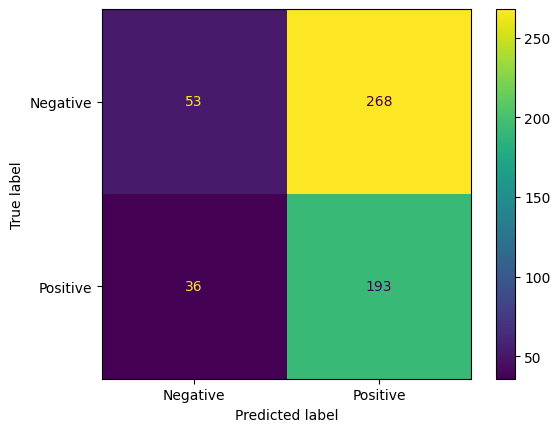

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the training data
validate_y_pred = lasso.predict(validate_x)
validate_y_pred_class = [1 if pred > 0.5 else 0 for pred in validate_y_pred]

# Generate the confusion matrix
conf_matrix = confusion_matrix(validate_y, validate_y_pred_class)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot()

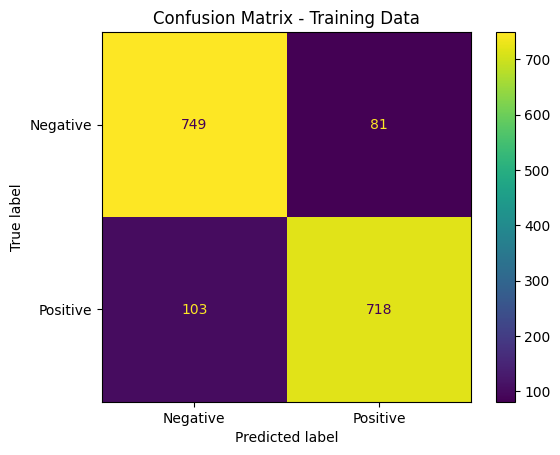

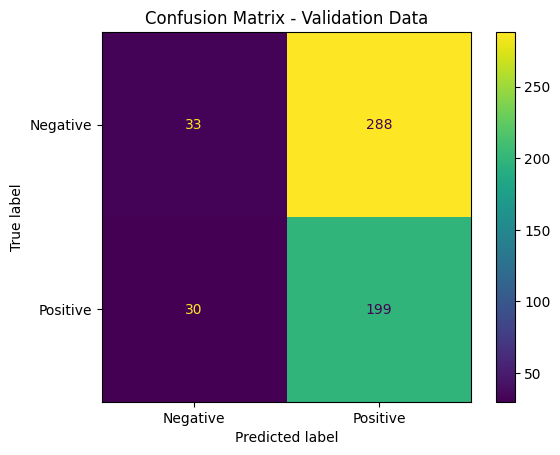

In [33]:
# Predict on the training data
train_y_pred_rf = rf_classifier.predict(train_x)

# Generate the confusion matrix for training data
conf_matrix_train = confusion_matrix(train_y, train_y_pred_rf)

# Display the confusion matrix with labels for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['Negative', 'Positive'])
disp_train.plot()
plt.title('Confusion Matrix - Training Data')
plt.show()

# Predict on the validation data
validate_y_pred_rf = rf_classifier.predict(validate_x)

# Generate the confusion matrix for validation data
conf_matrix_validate = confusion_matrix(validate_y, validate_y_pred_rf)

# Display the confusion matrix with labels for validation data
disp_validate = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_validate, display_labels=['Negative', 'Positive'])
disp_validate.plot()
plt.title('Confusion Matrix - Validation Data')
plt.show()